<a href="https://colab.research.google.com/github/saketkc/pyro-rethinking/blob/master/Chapters/03_Chapter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 03 - Sampling the Imaginary

In [ ]:
!pip install torch torchvision pyro-ppl proplot black blackcellmagic

In [ ]:
import warnings

import pandas as pd
import proplot as plot
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.ops.stats as stats
import pyro.optim
import seaborn as sns
import torch
import torch.distributions.constraints as constraints
import torch.tensor as tensor
from pyro.contrib.autoguide import AutoLaplaceApproximation

warnings.filterwarnings("ignore")
%pylab inline
pyro.set_rng_seed(42)

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

/usr/local/lib/python3.6/dist-packages/proplot/config.py:1454: ProPlotWarning: Rebuilding font cache.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Code 3.1

In [ ]:
pr_pv = tensor(0.95)
pr_pm = tensor(0.01)
pr_v = tensor(0.001)
pr_p = pr_pv * pr_v + pr_pm * (1 - pr_v)
pr_vp = pr_pv * pr_v / pr_p
pr_vp

tensor(0.0868)

### Code 3.2

In [ ]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = tensor([1.0] * 1000)
likelihood = dist.Binomial(total_count=9, probs=p_grid).log_prob(tensor(6.0)).exp()
unstd_posterior = likelihood * prior
posterior = unstd_posterior / unstd_posterior.sum()

### Code 3.3

In [ ]:
# samples = posterior[torch.randint(len(posterior), (10000,1))].numpy().flatten()
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([10000]))
# .numpy().flatten()

### Code 3.4-3.5


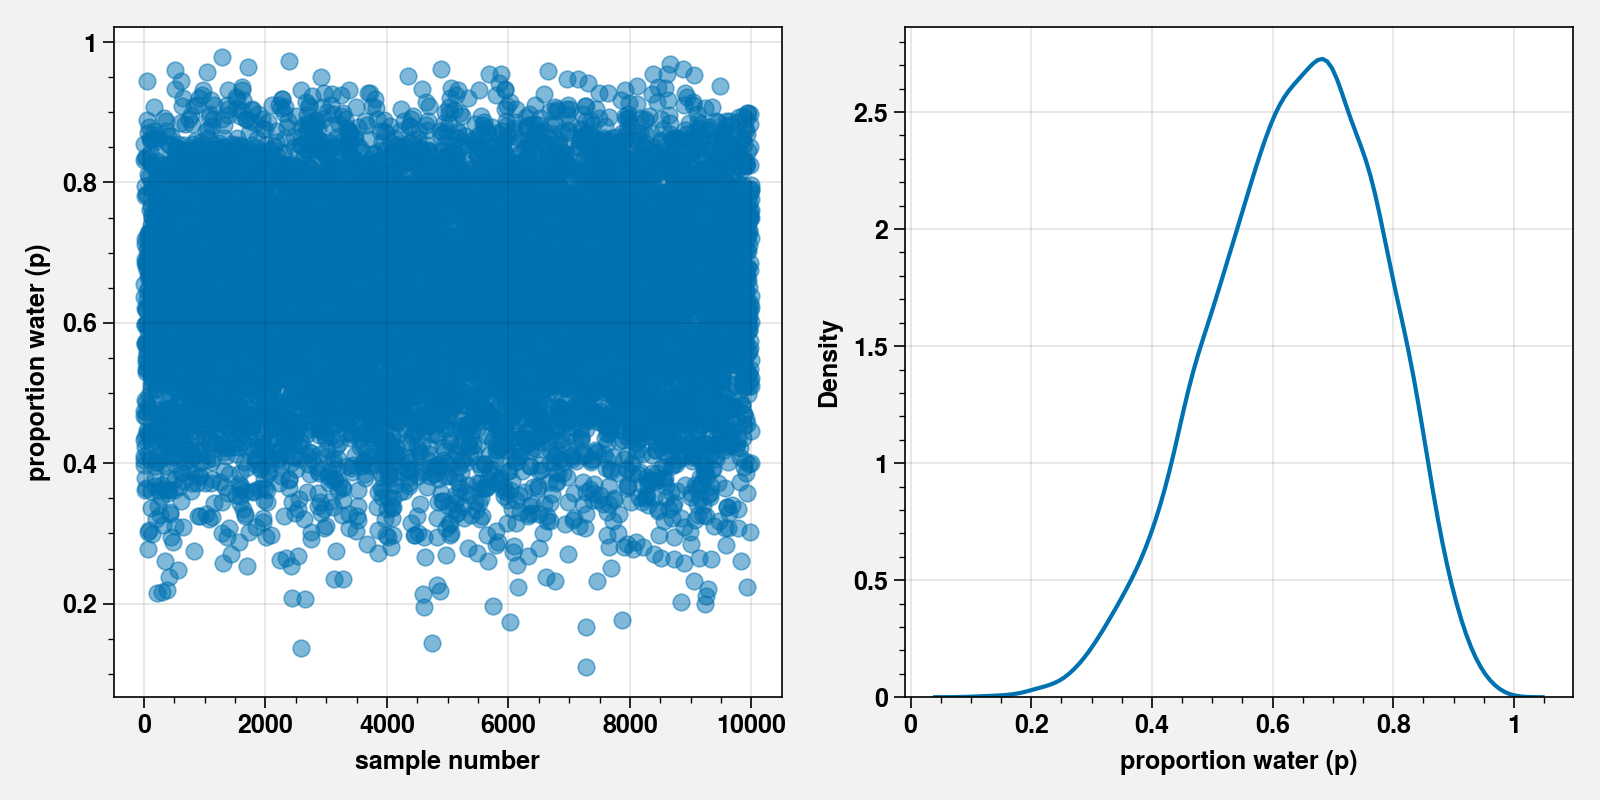

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(121)
ax.scatter(range(len(samples)), samples.numpy().flatten(), alpha=0.5)
ax.set_ylabel("proportion water (p)")
ax.set_xlabel("sample number")
ax = plt.subplot(122)
sns.kdeplot(samples.numpy().flatten(), ax=ax)
ax.set_ylabel("Density")
ax.set_xlabel("proportion water (p)")
fig.tight_layout()

### Code 3.6

In [ ]:
torch.sum(posterior[p_grid < 0.5])

tensor(0.1719)

### Code 3.7

In [ ]:
# from posterior
(samples < 0.5).sum(dtype=float) / 10000

tensor(0.1710, dtype=torch.float64)

### Code 3.8

In [ ]:
# probability values between 0. 5 and 0.75
((samples > 0.5) & (samples < 0.75)).sum(dtype=float) / 10000

tensor(0.5988, dtype=torch.float64)

### Code 3.9

In [ ]:
prob = 0.8
samples.kthvalue(int(len(samples) * prob), dim=0)[0].data.numpy()

array(0.7627628, dtype=float32)

### Code 3.10

In [ ]:
prob = 0.9


def my_quantile(samples, prob=0.9):

    lower_quantile = (
        samples.kthvalue(int(len(samples) * (1 - prob)), dim=0)[0].numpy().flatten()
    )
    upper_quantile = (
        samples.kthvalue(int(len(samples) * prob), dim=0)[0].numpy().flatten()
    )
    return tensor([lower_quantile[0], upper_quantile[0]])


print(my_quantile(samples, prob=0.9))

# easier way out - use stats
stats.pi(samples, 0.9)

tensor([0.4525, 0.8148])


tensor([0.3974, 0.8488])

### Code 3.11

In [ ]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = tensor([1.0] * 1000)
likelihood = dist.Binomial(total_count=3, probs=p_grid).log_prob(tensor(3.0)).exp()
unstd_posterior = likelihood * prior
posterior = unstd_posterior / unstd_posterior.sum()
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([10000]))

### Code 3.12

In [ ]:
def my_PI(samples, prob=0.9):
    upper_quantile = (
        samples.kthvalue(int(len(samples) * (1 - prob / 2)), dim=0)[0]
        .data.numpy()
        .flatten()
    )
    lower_quantile = (
        samples.kthvalue(int(len(samples) * prob / 2), dim=0)[0].data.numpy().flatten()
    )
    return tensor([lower_quantile[0], upper_quantile[0]])


print(my_PI(samples, prob=0.5))

# easier way - use pyro
stats.pi(samples, 0.5)

tensor([0.7077, 0.9319])


tensor([0.7085, 0.9319])

In [ ]:
def my_HPDI(posterior_samples, prob):
    sorted_samples, _ = posterior_samples.sort()
    skip_index = int(np.ceil(prob * len(sorted_samples)))
    n_CI = len(sorted_samples) - skip_index
    width_CI = tensor(
        [sorted_samples[i + skip_index] - sorted_samples[i] for i in range(n_CI)]
    )

    lower_CI = sorted_samples[width_CI.argmin()]
    upper_CI = sorted_samples[width_CI.argmin() + skip_index]
    return tensor([lower_CI, upper_CI])

### Code 3.13

In [ ]:
print(my_HPDI(samples, 0.5))

# easier way - use pyro

stats.hpdi(samples, 0.5)

tensor([0.8418, 1.0000])


tensor([0.8418, 1.0000])

### Code 3.14

In [ ]:
p_grid[posterior.argmax()]

tensor(1.)

### Code 3.15

In [ ]:
# chainmode
samples.mode()

torch.return_types.mode(values=tensor(0.9960), indices=tensor(9762))

In [ ]:
h = samples.std() * (4 / 3 / len(samples)) ** (1 / 5)
p_grid = torch.linspace(samples.min(), samples.max(), 1000)
y = dist.Normal(samples, h).log_prob(p_grid.unsqueeze(-1)).logsumexp(-1).exp()
p_grid[y.argmax()]

tensor(0.9492)

### Code 3.16

In [ ]:
print(samples.mean())
print(samples.median())

tensor(0.8004)
tensor(0.8418)


### Code 3.17

In [ ]:
(posterior * torch.abs(0.5 - p_grid)).sum()

tensor(0.3328)

### Code 3.18

In [ ]:
loss = (posterior * (p_grid.unsqueeze(1) - p_grid).abs()).sum(1)

### Code 3.19

In [ ]:
p_grid[loss.argmin()]

tensor(0.8631)

### Code 3.20

In [ ]:
dist.Binomial(total_count=2, probs=0.7).log_prob(torch.arange(3.0)).exp()

tensor([0.0900, 0.4200, 0.4900])

### Code 3.21

In [ ]:
dist.Binomial(total_count=1, probs=0.7).sample()

tensor(0.)

### Code 3.22

In [ ]:
dist.Binomial(total_count=2, probs=0.7).sample(torch.Size([10]))

tensor([2., 1., 1., 1., 1., 2., 1., 2., 0., 2.])

### Code 3.23

In [ ]:
dummy_w = dist.Binomial(total_count=2, probs=0.7).sample(torch.Size([100000]))
dummy_w.long().bincount().float() / 100000

tensor([0.0882, 0.4236, 0.4883])

### Code 3.24

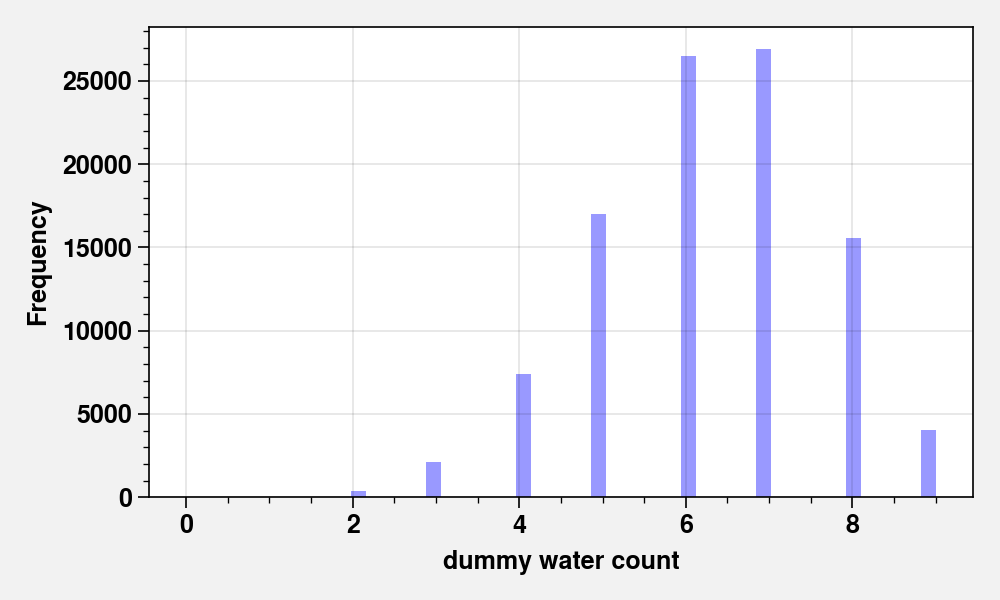

In [ ]:
dummy_w = dist.Binomial(total_count=9, probs=0.7).sample(torch.Size([100000]))
fig, ax = plt.subplots(figsize=(5, 3))
sns.distplot(dummy_w.numpy().flatten(), kde=False, ax=ax, color="blue")
ax.set_xlabel("dummy water count")
ax.set_ylabel("Frequency")
fig.tight_layout()

### Code 3.25

In [ ]:
w = dist.Binomial(total_count=9, probs=0.6).sample(torch.Size([10000]))

### Code 3.26

In [ ]:
w = dist.Binomial(total_count=9, probs=samples).sample(torch.Size([10000]))